In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel, TfidfModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [2]:
# set plot options
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_colour ="#00bfbf"


In [3]:
data = pd.read_csv('fake_news_data.csv')
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


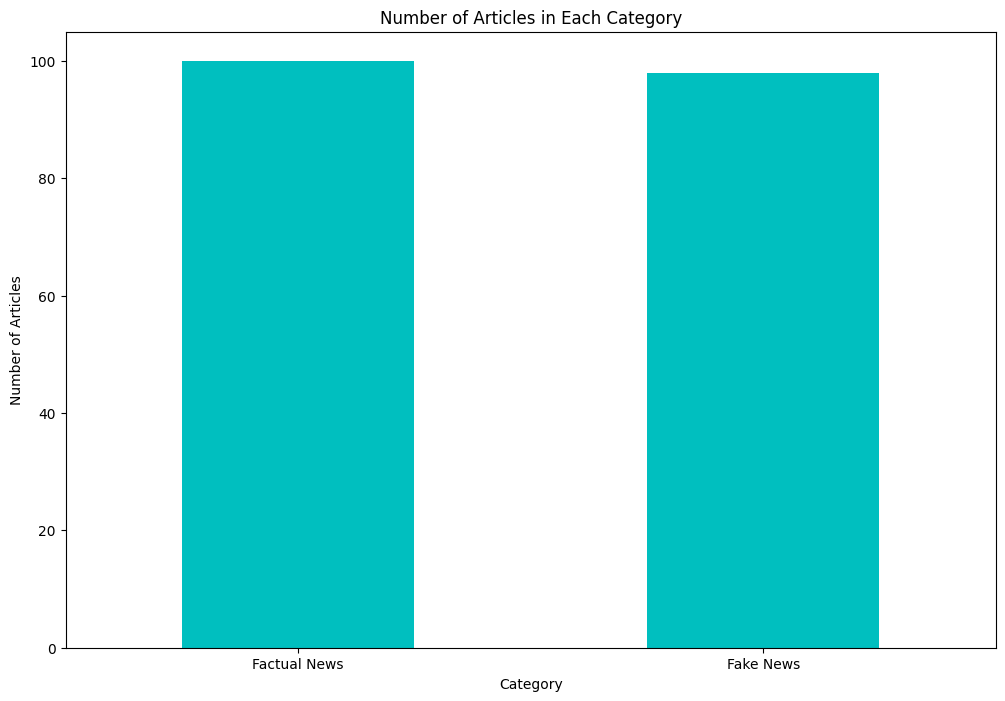

In [5]:
# plot the number of articles in each category
data['fake_or_factual'].value_counts().plot(kind='bar', color=default_plot_colour)
plt.title('Number of Articles in Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.show()

# POS Tagging

**Part-of-Speech (POS) tagging** is the process of labeling each word in a text with its grammatical role, such as noun, verb, adjective, etc. POS tagging helps computers understand the structure and meaning of sentences by identifying how words function in context.

**Common POS tags include:**
- Noun (N): person, place, thing (e.g., "dog", "city")
- Verb (V): action or state (e.g., "run", "is")
- Adjective (ADJ): describes a noun (e.g., "happy", "blue")
- Adverb (ADV): modifies a verb, adjective, or adverb (e.g., "quickly", "very")
- Pronoun (PRON): replaces a noun (e.g., "he", "they")
- Preposition (PREP): shows relationship (e.g., "in", "on")
- Conjunction (CONJ): connects words or phrases (e.g., "and", "but")
- Determiner (DET): specifies a noun (e.g., "the", "some")

**Why is POS tagging important?**
- Enables deeper text analysis and understanding
- Useful for information extraction, named entity recognition, and syntactic parsing
- Helps improve the accuracy of downstream NLP tasks like sentiment analysis and machine translation




In [6]:
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 5.1 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
fake_news = data[data['fake_or_factual'] == 'Fake News']
fake_news.head()


,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News


In [8]:

factual_news = data[data['fake_or_factual'] == 'Factual News']
factual_news.head()

,title,text,date,fake_or_factual
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News
11,Kerry says can't comment on content of Clinton...,QUEBEC CITY (Reuters) - U.S. Secretary of Stat...,"January 29, 2016",Factual News


This approach is much faster than looping over each text with `nlp(text)` because `nlp.pipe` processes texts in batches and is optimized for large datasets.

In [9]:
# fake_spacydocs = [nlp(text) for text in fake_news['text']]
fake_spacydocs = list( nlp.pipe(fake_news['text']))  # This line is incorrect, it should be the previous one
factual_spacydocs = list( nlp.pipe(factual_news['text']))  # This line is incorrect, it should be the previous one
# print information about the first document
print(fake_spacydocs[0].text)
print(fake_spacydocs[0].ents)
print(fake_spacydocs[0].ents[0].label_)
print(fake_spacydocs[0].ents[0].text)

There are two small problems with your analogy Susan  Jesus was NOT a Muslim and Joseph traveled to Bethlehem with Mary. For anyone who s not paying attention there don t appear to be many female refugees accompanying male Muslim  refugees  to Greece.Susan Sarandon spent the Christmas holiday on the Greek island of Lesbos assisting international organizations with the mounting Syrian refugee crisis   a crisis, she says, that recalls the travails of Joseph and Mary on their way to the Inn in Bethlehem.In a column for the Huffington Post and RYOT, the 69-year-old Oscar-winning actress described meeting a 16-year-old girl who had apparently given birth shortly before arriving on the island. I smile and approach her, but without a translator, our conversation is basic-friendly,  Sarandon wrote of her experience.  She takes the bundle next to her and opens it to me. Inside is a perfect, rosy, newborn. The actress continues:She is beaming, so proud. How did this young girl, just having given

In [10]:
def extract_token_tags ( doc: spacy.tokens.doc.Doc):
    """
    Extracts token text and part-of-speech tags from a spaCy Doc object.
    
    Args:
        doc (spacy.tokens.doc.Doc): The spaCy Doc object to extract from.
        
    Returns:
        list: A list of tuples containing token text and its part-of-speech tag.
    """
    return [(token.text, token.ent_type_ ,token.pos_) for token in doc]

In [11]:
fake_tags_df = []
columns = ['token', 'ner_tag', 'pos_tag']


In [12]:

for doc in fake_spacydocs:
    tags = extract_token_tags(doc)
    tags = pd.DataFrame(tags, columns=columns)
    fake_tags_df.append(tags)
fake_tags_df = pd.concat(fake_tags_df, ignore_index=True)
fake_tags_df.head()

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN


In [13]:
factual_tags_df = []
# the columns are the same as for the fake news

In [14]:
factual_tags_df = [ pd.DataFrame(extract_token_tags(doc), columns=columns) for doc in factual_spacydocs ]
factual_tags_df = pd.concat(factual_tags_df, ignore_index=True)
factual_tags_df.head()

,token,ner_tag,pos_tag
0,WASHINGTON,GPE,PROPN
1,(,,PUNCT
2,Reuters,ORG,PROPN
3,),,PUNCT
4,-,,PUNCT


# POS Frequency Analysis

This section analyzes the frequency of different part-of-speech tags in both fake and factual news articles. By comparing POS tag distributions, we can identify linguistic patterns that may distinguish fake news from factual reporting.

**What this analysis does:**
- Counts how often each grammatical category (NOUN, VERB, ADJ, etc.) appears in fake vs factual news
- Groups tokens by their part-of-speech tags to find the most common word types
- Compares linguistic patterns between fake and factual news articles
- Provides quantitative evidence of grammatical differences in news types

**Key insights:**
- Shows which grammatical categories (nouns, verbs, adjectives, etc.) are most common in each news type
- Helps identify potential linguistic markers for fake news detection
- Provides foundation for feature engineering in classification models

In [15]:
pos_counts_fake = fake_tags_df \
    .groupby(['token', 'pos_tag']) \
    .size() \
    .reset_index(name='counts') \
    .sort_values(by='counts', ascending=False)
# display the top 10 most common tokens and their part-of-speech tags
pos_counts_fake.head(10)

,token,pos_tag,counts
29,",",PUNCT,1908
7451,the,DET,1834
41,.,PUNCT,1530
5766,of,ADP,922
2665,and,CCONJ,875
2449,a,DET,805
0,,SPACE,795
7528,to,PART,767
4921,in,ADP,668
5099,is,AUX,419


In [16]:
pos_counts_factual = factual_tags_df \
    .groupby(['token', 'pos_tag']) \
    .size() \
    .reset_index(name='counts') \
    .sort_values(by='counts', ascending=False)
# display the top 10 most common tokens and their part-of-speech tags
pos_counts_factual.head(10)

,token,pos_tag,counts
6145,the,DET,1903
14,",",PUNCT,1698
21,.,PUNCT,1382
4716,of,ADP,884
1898,a,DET,789
2093,and,CCONJ,757
4005,in,ADP,671
6205,to,PART,660
4743,on,ADP,482
5567,said,VERB,451


## POS Tag Frequency Analysis

This code analyzes the diversity of vocabulary within each part-of-speech category in fake news articles:

**What it does:**
- Groups the data by POS tags (NOUN, VERB, ADJ, etc.)
- Counts how many **unique token types** exist for each POS tag
- Sorts results in descending order to show categories with the most vocabulary diversity
- Displays the top 10 POS tags with the highest token variety

**What the results tell us:**
- Which grammatical categories have the richest vocabulary in fake news
- The linguistic complexity and diversity of different word types
- Potential indicators of writing style differences between fake and factual news

In [18]:
pos_counts_fake.groupby(['pos_tag'])['token'] \
    .count() \
    .sort_values(ascending=False)[:10]


pos_tag
NOUN     2586
VERB     1817
PROPN    1672
ADJ       882
ADV       413
NUM       221
PRON       96
ADP        89
AUX        62
SCONJ      51
Name: token, dtype: int64

In [19]:
pos_counts_factual.groupby(['pos_tag'])['token'] \
    .count() \
    .sort_values(ascending=False)[:10]


pos_tag
NOUN     2179
VERB     1539
PROPN    1379
ADJ       747
ADV       263
NUM       205
PRON       79
ADP        70
AUX        43
SCONJ      42
Name: token, dtype: int64

In [23]:
pos_counts_fake[pos_counts_fake['pos_tag'] == 'NOUN'].sort_values(by='counts', ascending=False)[:10]
    

,token,pos_tag,counts
5981,people,NOUN,77
7349,t,NOUN,65
6216,president,NOUN,58
7960,women,NOUN,55
7516,time,NOUN,52
3138,campaign,NOUN,44
8011,year,NOUN,44
4581,government,NOUN,41
8013,years,NOUN,40
5213,law,NOUN,40


In [24]:
pos_counts_factual[pos_counts_factual['pos_tag'] == 'NOUN'].sort_values(by='counts', ascending=False)[:10]


,token,pos_tag,counts
3738,government,NOUN,71
6618,year,NOUN,64
5901,state,NOUN,57
2360,bill,NOUN,55
1975,administration,NOUN,51
5066,president,NOUN,49
3277,election,NOUN,48
4919,people,NOUN,45
4786,order,NOUN,45
4259,law,NOUN,42


# Cleanup the code

In [22]:
factual_news.head()

,title,text,date,fake_or_factual
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News
11,Kerry says can't comment on content of Clinton...,QUEBEC CITY (Reuters) - U.S. Secretary of Stat...,"January 29, 2016",Factual News


In [ ]:
factual_news.apply( lambda row: 